In [89]:
from itertools import combinations
import pickle
import numpy as np
from numpy.linalg import norm
from numpy import dot
import seaborn as sns
import matplotlib.pyplot as plt

In [90]:
def get_coeff_vecs():
    with open("../data/coeff_vecs.txt", "r") as f:
        f = f.read().split("\n\n\n")
        noun_dict = {}
        for noun_vec in f:
            split = noun_vec.split("\n\n")
            noun = split[0].split()[2][:-1]
            
            vec = split[1]
            vec = [item.strip().replace("(", "").replace(")", "") for item in vec.split(",\n")]
            vec = [(item.split()[:-1], item.split()[-1]) for item in vec]

            vec = sorted(vec, key=lambda x: x[0])
            vec = {item[0][0]: float(item[1]) for item in vec}

            noun_dict[noun] = vec

    return noun_dict

In [91]:
coeff_vecs = get_coeff_vecs()

In [92]:
def generate_combinations(n, k):
    elements = range(n)
    all_combinations = list(combinations(elements, k))
    return all_combinations

n = 60
k = 2
combs = generate_combinations(n, k)
print(len(combs), combs)

1770 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1,

In [93]:
noun_vecs, verb_vecs = pickle.load(open("../data/vecs.pkl", "rb"))
nouns = list(noun_vecs.keys())

noun_vecs = {k: np.array(noun_vecs[k]) for k in noun_vecs}
verb_vecs = {k: np.array(verb_vecs[k]) for k in verb_vecs}

In [94]:
def l2(a, b):
    return norm(np.subtract(a, b))

In [95]:
def cos_sim_loss(a, b):
    return -(dot(a, b) / (norm(a) * norm(b)))

In [96]:
def mse(a, b):
    return np.mean((a - b) ** 2)

In [97]:
def check_if_not_confused(t1, t2, p1, p2, loss_func):
    return int(loss_func(t1, p1) + loss_func(t2, p2) < loss_func(t1, p2) + loss_func(t2, p1))

In [98]:
corrects_l2 = 0
corrects_cossim = 0
corrects_mse = 0

conf_mat = np.zeros((60, 60))
dist_mat = np.zeros((60, 60))

for comb in combs:
    n1, n2 = nouns[comb[0]], nouns[comb[1]]
    coeffs1, coeffs2 = coeff_vecs[n1], coeff_vecs[n2]

    p1 = np.add.reduce([coeffs1[verb] * verb_vecs[verb] for verb in verb_vecs])
    p2 = np.add.reduce([coeffs2[verb] * verb_vecs[verb] for verb in verb_vecs])

    t1 = noun_vecs[n1]
    t2 = noun_vecs[n2]

    p1, p2 = p1.flat, p2.flat

    t1_to_p1 = l2(t1, p1)
    t1_to_p2 = l2(t1, p2)
    t2_to_p1 = l2(t2, p1)
    t2_to_p2 = l2(t2, p2)

    if t1_to_p2 < t1_to_p1:
        conf_mat[(comb[0], comb[1])] = t1_to_p1 / t1_to_p2
    
    if t2_to_p1 < t2_to_p2:
        conf_mat[(comb[1], comb[0])] = t2_to_p2 / t2_to_p1

    dist_mat[(comb[0], comb[0])] += t1_to_p1
    dist_mat[(comb[0], comb[1])] += t1_to_p2
    dist_mat[(comb[1], comb[0])] += t2_to_p1
    dist_mat[(comb[1], comb[1])] += t2_to_p2

    corrects_l2 += check_if_not_confused(t1, t2, p1, p2, l2)
    corrects_cossim += check_if_not_confused(t1, t2, p1, p2, cos_sim_loss)
    corrects_mse += check_if_not_confused(t1, t2, p1, p2, mse)

print(corrects_l2 / len(combs), corrects_cossim / len(combs), corrects_mse / len(combs))

for i in range(60):
    dist_mat[i, i] /= 60

0.9124293785310734 0.9096045197740112 0.8977401129943503


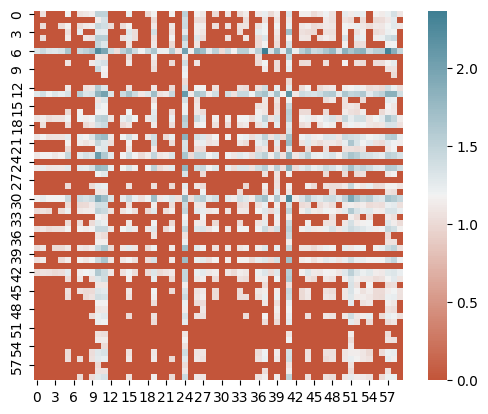

0.39444444444444443


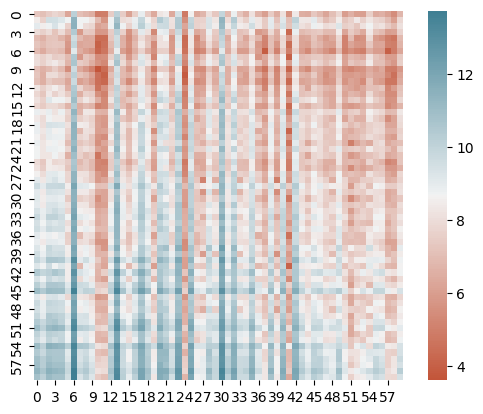

In [99]:
ax = sns.heatmap(conf_mat, cmap=sns.diverging_palette(20, 220, n=200), square=True)
plt.show()
plt.cla()
print(np.count_nonzero(conf_mat) / 3600)
ax = sns.heatmap(dist_mat, cmap=sns.diverging_palette(20, 220, n=200), square=True)
plt.show()